# Day 2 exercises: Stability threshold and high order symplectic integrators
Today's exercises will be mainly about the stability threshold, i.e., the maximum admissable time step $h_{max}$ for which the numerical scheme under consideration is stable. For computational purposes it is desireable to be able to use large stepsizes since using a larger step size allows to simulate longer (in physical time) trajectories with the same computational budget. 


## Exercise 1 (Double Pendulum)
In what follows we will consider a simple double pendulum in $\mathbb{R}^2$ consisting of two particles $q_1 = (q_{1,x},q_{1,y})$, and $q_2 = (q_{2,x},q_{2,y})$, which interact with a harmonic spring of rest length $r_{12}>0$ and stiffness constant $k_{12}>0$. The first particle $q_1$ feels fhe force of a harmonic spring which is connected with the origin has a rest length of $r_1$ and stiffnes constant $k_1$. The below figure illustrates this model 

<img src="./figures/DP-2springs-labeled.pdf">

You can find an implementation of this model as `DoublePendulum` in the file ./miniMD/model.py

# Tasks

a)
- create an instance of `DoublePendulum` with the parametrisation $k_1=1,k_{12}=1,r_1=r2=5$. Use the Velocity Verlet integrator to simulate a trajectory of physical time $T = 100$ starting at $q = [5,0,10,0]$ and $p = [1,1,1,1]$. Create plots time vs q and time vs total Energy. Empirically determine the value of the maximum addmissible time step $h_{max}$.
- If you change the value of stiffness coefficient $k_1$ to $k_1=10, k_1=100,k_1=1000$, how does the value of $h_{max}$ change? In the case $k_1=1000$ what is the minimum number of time steps you require? 

b)

For $k_1=1000, k_{12}=1$ the double pendulum satisfies the characteristics of a multi-scale system, i.e., there is a scale separation between the degrees of freedom describing the relative movement of the two particles and the degrees of freedom describing the movement of the first particle relative to the origin. In such a situation it makes sense to decompose the gradient force as 

$$
-\nabla U(q) = -\nabla U_{f}(q) -\nabla U_{s}(q),
$$

where $-\nabla U_{f}(q)$ denotes the "fast" components of the force, which specifies the motion of the first particle relative to the origin, and $-\nabla U_{s}(q)$ denotes the "slow" components of the force, which specifies the motion of the particles relative to each other. 

One consequence of this scale separation which is of great importance in the computational context is that the resulting equations of motion become a stiff ODE. One common approach in Molecular Dynamics which allows to leviate this issue in the case of a clear scale separation is multiple time stepping: 

- In integrators.py you can find the class RESPA which is supposed to implement the multiple time stepping method RESPA. Add the missing traverse function. You can find a decsription of the RESPA method on pages 145-152 in Ben's book. $-\nabla U_{f}(q)$, and $-\nabla U_{s}(q)$, are implemented in the class `DoublePendulum` as `comp_fastForce(self, q)` and `comp_slowForce(self, q)`, respectively.
- Using RESPA and the parametrization of the double pendulum as described in a) with $k_1 = 1000$ what is the maximum addmissible time step you can achieve now. Discounting the number of substeps, what is the total number of time steps required to integrate the system for a physical time of $T=100$? Create again a plot "time vs q". Does it look similar as what you obtained in a)?

c) 

Yet another way of increasing the maximum admissable time step is by replacing the stiff spring between the first particle and the origin by a static rod. Doing that one obtains a contrained Hamiltonian system of the form

$$
\begin{aligned}
\dot{q} &= p,\\
\dot{p} &= -\nabla U(q) - g^{\prime}(q) \lambda,\\
g(q) &=0, 
\end{aligned}
$$
with $g(q) = q_{1,x}^2+q_{1,y}^2 - r_1^2$. 

- In the file ./constrainedMD.py, you can find the class `DPConstraint` implementing exactly the above mentioned constraint for a double pendulum. Use the integrator `Rattle`, which you can find in the same file to simulate the system. Initialise `Rattle` with in instance of `DoublePendulum` where you set $k_1=0$. Create again a plot "time vs q". Does it look similat to what you obtained in a). Empirically determine  the maximum addmissible step size and the minimum number of time steps required to integrate the system for a physical time of $T=100$
- How does the maximum addmissible step size change when you reduce the value of $r_1$. In particular, what happens if $r_1<<1$?

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from miniMD import models, integrators, outputshedulers as outp

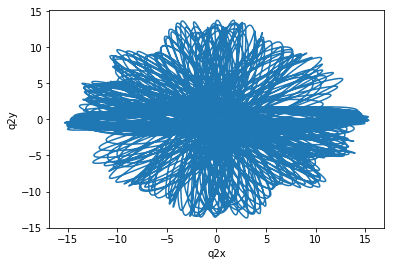

In [23]:
model = models.DoublePendulum(k1=10.0, r1=1.0,k12=1.0, r12=1.0)
integrator = integrators.VelocityVerlet(model, h=.01)
op = outp.BufferedOutputsheduler(integrator, 
                                 Nsteps=int(1000.0/integrator.h), 
                                 varname_list=['q','p'], 
                                 modprnt=1)
dim=model.dim
initial_values ={'p': np.ones(dim), 'q': np.array([0,5.0, 0.0, 10])}
integrator.run(initial_values=initial_values)
fig,ax = plt.subplots()
ax.plot(op.traj_q[:,2],op.traj_q[:,3])
ax.set_xlabel('q2x')
ax.set_ylabel('q2y')
plt.show()

## Exercise 2 (Shadow Hamiltonian, Harmonic Oscillator)

The shadow Hamiltonian of the Velocity Verlet scheme applied to a single degree of freedom system of the form
$$H(q,p) = U(q) + \frac{1}{2}p^2$$
is 
$$
\begin{aligned}
H_h(q,p) &= H(q,p) + \frac{h^2}{24}\left (  2 p U^{\prime\prime}(q)p - (U^{\prime}(q))^2 \right )\\
&+h^4 \left ( \frac{1}{720}p^4 U^{\prime\prime\prime\prime} - \frac{1}{120} p^2  U^{\prime} (q)U^{\prime\prime\prime}(q)-\frac{1}{240} (U^{\prime}(q) )^2 U^{\prime\prime}(q) - \frac{1}{60} p^2 \left (  (U^{\prime\prime}(q) )^2 + U^{\prime}(q)U^{\prime\prime\prime}(q)\right ) \right )\\
&+ O(h^6).
\end{aligned}
$$

In general, this series is only formal. An important exception is the case where $U$ is a harmonic oscillator:
### Task
- Show that the shadow Hamiltonian for the Velocity Verlet method with step size $h$ in the case of an harmonic oscillator $U(q) = \frac{k}{2}q^2$ is given by
$$
H_h(q,p) = (q,p)C(h)\begin{pmatrix}
q\\
p
\end{pmatrix},
$$
with 
$$
C(h) =\left(
\begin{array}{cc}
k-\frac{h^2 k^2}{4} & 0 \\
 0 & 1 \\
\end{array}
\right)
$$
Hint: You can use the fact that in the case of $U(q) = \frac{k}{2}q^2$, one update of the Verlet scheme can be written as a linear recursion of the form
$$
\begin{pmatrix}
q_{n+1}\\
p_{n+1}
\end{pmatrix}
= R(h) 
\begin{pmatrix}
q_{n}\\
p_{n}
\end{pmatrix},
$$
with
$$
R(h):= 
\left(
\begin{array}{cc}
 1-\frac{h^2 k}{2} & h \\
 -h k\left(1-\frac{h^2 k}{4}\right) & 1-\frac{h^2 k}{2} \\
\end{array}
\right).
$$
Thus, it is sufficient to show that $R(h)^{T}C(h)R(h)=C(h)$.
- Verify the above observation numerically by generating a plot using the Velocity Verlet scheme for the above described harmonic system and create a plot of the form "time vs H_h". You should see no variation in the value of H_h over time


## Exercise 3 (Higher order integrators)

- Implement the Yoshida 4 scheme described in Ben's book on page 110. Following the same setup and sequence of steps as in Exercise 2 of day 1 test whether the implementation of your integrator is correct (You should again observe that the total energy is approximately conserved). Create a plot where you compare the convergence orders of the long time error in energy as $h\rightarrow 0$ between the symplectic Euler, the Velocity Verlet method and the Yoshida 4 scheme.

## Exercise 4 (Resonances in RESPA)
One issue with RESPA is that resonance effects might occur for certain values of the step size $h$. A simple example is discussed in Ben's book on page 145-148. Implement the respective system as a subclass of `MultiScaleModel` and investigate the behaviour of RESPA at the critical values of the step size $h$. 